In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
!date
!whoami
!pwd

Thu Sep 30 17:00:31 PDT 2021
ndbs
/Users/ndbs/notebooks


# Test vectorization of scipy.stats distributions

In [2]:
test_dist = stats.norm([50,0],[3,1]) # Create two different normal distributions in one object
print(test_dist.stats())
rvs = test_dist.rvs(size=(3,4,2)) # Last dimension must match number of distributions
print("rvs\n", rvs) # 
print("rvs.T\n", rvs.T)

(array([50.,  0.]), array([9., 1.]))
rvs
 [[[ 5.15212398e+01 -1.75928779e+00]
  [ 4.75109328e+01  8.90878719e-01]
  [ 4.71435086e+01 -4.92225920e-01]
  [ 4.67972535e+01 -2.93263434e+00]]

 [[ 5.57526475e+01 -8.53606932e-02]
  [ 5.07123584e+01  6.95960964e-01]
  [ 4.95009398e+01 -1.48192772e+00]
  [ 4.90806885e+01 -9.61902176e-01]]

 [[ 4.86679368e+01 -1.59145925e-02]
  [ 4.82292839e+01  1.40061981e-01]
  [ 4.95785200e+01 -4.86410146e-01]
  [ 4.67037974e+01  5.76638386e-01]]]
rvs.T
 [[[ 5.15212398e+01  5.57526475e+01  4.86679368e+01]
  [ 4.75109328e+01  5.07123584e+01  4.82292839e+01]
  [ 4.71435086e+01  4.95009398e+01  4.95785200e+01]
  [ 4.67972535e+01  4.90806885e+01  4.67037974e+01]]

 [[-1.75928779e+00 -8.53606932e-02 -1.59145925e-02]
  [ 8.90878719e-01  6.95960964e-01  1.40061981e-01]
  [-4.92225920e-01 -1.48192772e+00 -4.86410146e-01]
  [-2.93263434e+00 -9.61902176e-01  5.76638386e-01]]]


# Copy functions from `prob_utils.py` and edit them

https://github.com/ihmeuw/vivarium_data_analysis/blob/main/probability/prob_utils.py

https://github.com/ihmeuw/vivarium_helpers/blob/main/src/vivarium_helpers/prob_utils.py

In [3]:
def normal_stdev_from_quantiles(quantiles, quantile_ranks):
    """
    Computes the standard deviation of a normal distribution that two quantiles
    with the specified ranks.
    """
#     # If q = quantile, mu = mean, and sigma = std deviation, then
#     # q = mu + q'*sigma, where q' is the standard normal quantile
#     # and q is the transformed quantile, so sigma = (q-mu)/q'
#     return (quantile - mean) / scipy.stats.norm().ppf(quantile_rank)
    # quantiles of the standard normal distribution with specified quantile_ranks
    stdnorm_quantiles = stats.norm.ppf(quantile_ranks)
    # Find sigma such that (upper - lower) = (q1 - q0)*sigma, where q1 and q2 are the standard normal
    # quantiles with the specified ranks
    stdev = (quantiles[1] - quantiles[0]) / (stdnorm_quantiles[1] - stdnorm_quantiles[0])
    return stdev

def beta_dist_from_mean_var(mean, variance):
    """
    Returns a beta distribution with the specified mean and variance.
    I.e. implements the method of moments for the Beta distribution.
    """
    if mean <= 0 or mean >= 1:
        raise ValueError("Mean must be in the interval (0,1)")
    if variance >= mean*(1-mean):
        raise ValueError(f"Variance too large: {variance} >= {mean*(1-mean)}")

    # For derivations of these formulas, see:
    # https://en.wikipedia.org/wiki/Beta_distribution#Mean_and_variance
    a = mean*(mean*(1-mean)/variance - 1)
    b = (1-mean)*(mean*(1-mean)/variance - 1)
    return stats.beta(a,b) # a,b can be recovered from dist.args

def beta_dist_from_mean_lower_upper(mean, lower, upper, quantile_ranks=(.025, .975)):
    """
    Returns a scipy.stats Beta distribution with the specified mean and
    quantiles of ranks approximately equal to quantile_ranks.
    This is achieved by specifying that the variance of the Beta distribution
    is equal to the variance of a normal distribution with the same mean and
    the specified quantile. This will not work well if the variance of the required Beta
    distribution is too large (i.e. if the probability is concentrated near 0 and 1
    instead of near the mean), because there is no normal distribution with this behavior,
    and it also won't work well if lower and upper are not close to the actual quantiles
    for the specified ranks.
    """
    variance = normal_stdev_from_quantiles((lower, upper), quantile_ranks)**2
    return beta_dist_from_mean_var(mean, variance)

def lognorm_dist_from_mean_var(mean, variance):
    """Method of moments for lognormal distribution.
    See https://en.wikipedia.org/wiki/Log-normal_distribution
    """
    mean_squared = mean**2
    median = mean_squared / np.sqrt(variance + mean_squared)
    # median = mean / np.sqrt(1+ variance / mean_squared)
    sigma_squared = np.log(1+ variance / mean_squared)
    return stats.lognorm(s=np.sqrt(sigma_squared), scale=median)

def normal_dist_from_mean_var(mean, variance):
    """Method of moments for normal distribution."""
    return stats.norm(mean, np.sqrt(variance))

# Copy functions from the CIFF SAM project and edit them

In [4]:
def normal_dist_from_mean_lower_upper(mean, lower, upper, quantile_ranks=(0.025,0.975)):
    """Returns a frozen normal distribution with the specified mean, such that
    (lower, upper) are approximately equal to the quantiles with ranks
    (quantile_ranks[0], quantile_ranks[1]).
    """
    # quantiles of the standard normal distribution with specified quantile_ranks
    stdnorm_quantiles = stats.norm.ppf(quantile_ranks)
    # Find sigma such that (upper - lower) = (q1 - q0)*sigma, where q1 and q2 are the standard normal
    # quantiles with the specified ranks
    stdev = (upper - lower) / (stdnorm_quantiles[1] - stdnorm_quantiles[0])
    # Frozen normal distribution
    return stats.norm(loc=mean, scale=stdev)

def lognorm_dist_from_median_lower_upper(median, lower, upper, quantile_ranks=(0.025,0.975)):
    """Returns a frozen lognormal distribution with the specified median, such that
    the values (lower, upper) are approximately equal to the quantiles with ranks
    (quantile_ranks[0], quantile_ranks[1]). More precisely, if q0 and q1 are
    the quantiles of the returned distribution with ranks quantile_ranks[0]
    and quantile_ranks[1], respectively, then q1/q0 = upper/lower. If the 
    quantile ranks are symmetric about 0.5, lower and upper will coincide with
    q0 and q1 precisely when median^2 = lower*upper.
    """
    # Let Y ~ Norm(mu, sigma^2) and X = exp(Y), where mu = log(median)
    # so X ~ Lognorm(s=sigma, scale=exp(mu)) in scipy's notation.
    # We will determine sigma from the two specified quantiles lower and upper.
    
    # mean (and median) of the normal random variable Y = log(X)
    mu = np.log(median)
    # quantiles of the standard normal distribution corresponding to quantile_ranks
    stdnorm_quantiles = stats.norm.ppf(quantile_ranks)
    # quantiles of Y = log(X) corresponding to the quantiles (lower, upper) for X
    norm_quantiles = np.log([lower, upper])
    # standard deviation of Y = log(X) computed from the above quantiles for Y
    # and the corresponding standard normal quantiles
    sigma = (norm_quantiles[1] - norm_quantiles[0]) / (stdnorm_quantiles[1] - stdnorm_quantiles[0])
    # Frozen lognormal distribution for X = exp(Y)
    # (s=sigma is the shape parameter; the scale parameter is exp(mu), which equals the median)
    return stats.lognorm(s=sigma, scale=median)

def lognorm_dist_from_mean_lower_upper(mean, lower, upper, quantile_ranks=(0.025,0.975)):
    """Returns a frozen lognormal distribution with the specified mean, such that
    the values (lower, upper) are approximately equal to the quantiles with ranks
    (quantile_ranks[0], quantile_ranks[1])."""
    # Let Y ~ Norm(mu, sigma^2) and X = exp(Y), where mu = log(median)
    # so X ~ Lognorm(s=sigma, scale=exp(mu)) in scipy's notation.
    # Note that mean = exp(mu+sigma^2/2)
    
    # First we determine the unique sigma from the two specified quantiles lower and upper,
    # such that q1/q0 = upper/lower, where q0 and q1 are the quantiles of the specified ranks
    
    # quantiles of the standard normal distribution corresponding to quantile_ranks
    stdnorm_quantiles = stats.norm.ppf(quantile_ranks)
    # quantiles of Y = log(X) corresponding to the quantiles (lower, upper) for X
    norm_quantiles = np.log([lower, upper])
    # standard deviation of Y = log(X) computed from the above quantiles for Y
    # and the corresponding standard normal quantiles
    sigma = (norm_quantiles[1] - norm_quantiles[0]) / (stdnorm_quantiles[1] - stdnorm_quantiles[0])
    # Solve for median = exp(mu) in terms of mean and sigma
    median = mean * np.exp(-sigma**2 / 2)
    # Frozen lognormal distribution for X = exp(Y)
    # (s=sigma is the shape parameter; the scale parameter is exp(mu), which equals the median)
    return stats.lognorm(s=sigma, scale=median)

# Write an optimization routine to find a distribution with a specified mean or median (or potentially other parameter) and an interval with the specified probability, using a function that returns an approximate such distribution

In [5]:
def two_param_distribution_from_parameter_and_interval(
    distribution_fitter,
    parameter,
    lower,
    upper,
    desired_prob=.95,
    initial_p0=None,
    max_iterations=1000,
    rtol=1e-05,
    atol=1e-08
):
    """Returns a frozen scipy.stats distribution with the specified parameter, such that
    the probability content of the interval (lower, upper) is `desired_prob`,
    assuming such a distribution exists. If no such distribution exists, returns its best
    guess after `max_iterations` iterations of binary search.
    """
    min_prob = 0
    max_prob = 1-desired_prob
    # Initialize lower quantile rank p0
    p0 = max_prob/2 if initial_p0 is None else initial_p0
    # Do a binary search for the correct lower quantile rank p0
    found = False
    iterations = 0
    pvals = [p0]
    while not found and iterations < max_iterations:
        dist = distribution_fitter(parameter, lower, upper, (p0, p0+desired_prob))
        prob = dist.cdf(upper) - dist.cdf(lower)
        if np.allclose(prob, desired_prob, rtol, atol):
            found = True
        # These checks assume the parameter is consistent with the interval (lower, upper)
        elif (dist.median() > lower and prob < desired_prob) or (dist.median() < lower and prob >= desired_prob):
            # need to reduce spread -> move p0 left
            max_prob = p0
            p0 = (min_prob+p0)/2
#         else: # prob > desired_prob
        elif (dist.median() <= lower and prob < desired_prob) or (dist.median() > lower and prob > desired_prob):
            # need to increase spread -> move p0 right
            min_prob = p0
            p0 = (p0+max_prob)/2
        iterations +=1
        pvals += [p0]
    print(iterations)
    return dist, pvals

# Write another optimization function to utilize the method of moments to fit a distribution to a mean and an interval

In [6]:
def two_param_distribution_from_mean_and_interval(
    method_of_moments,
    mean,
    lower,
    upper,
    desired_prob=.95,
    variance_upper_bound=None,
    initial_variance=None,
    max_iterations=1000,
    rtol=1e-05,
    atol=1e-08
):
    """Find a continuous distribution with the specified mean and specified
    interval with probability content `desired_prob`.
    A solution is (I think) guaranteed to exist if lower <= mean <= upper, but
    not necessarily if mean < lower or mean > upper (though I think this routine will
    still find a solution in that case if one does exist).
    """
    if variance_upper_bound is None:
        v_upper_bound = 1
        def to_variance(v): # map [0,1] to [0,infinity]
            return v/(1-v)
        def from_variance(var):
            return var/(1+var) # inverse mapping from [0,infinity] to [0,1]
    else:
        v_upper_bound = variance_upper_bound
        def to_variance(v):
            return v
        def from_variance(var):
            return var
    v = v_upper_bound / 2 if initial_variance is None else from_variance(initial_variance)
    v_lower_bound = 0
    mean_inside = lower <= mean <= upper
    mean_outside = not mean_inside
    found = False
    iterations = 0
    while not found and iterations < max_iterations:
        dist = method_of_moments(mean, to_variance(v))
        prob = dist.cdf(upper) - dist.cdf(lower)
        if np.allclose(prob, desired_prob, rtol, atol):
            found = True
        elif (mean_inside and prob > desired_prob) or (mean_outside and prob < desired_prob):
            # Too much probability near the mean -> Need more spread -> increase v
            v_lower_bound = v
            v = (v+v_upper_bound)/2
        else:
            # (mean_inside and prob <= desired_prob) or (mean_outside and prob >= desired_prob)
            # Too little probability near the mean -> Need less spread -> decrease v
            v_upper_bound = v
            v = (v_lower_bound+v)/2
        iterations += 1
    print(iterations)
    return dist

In [7]:
3 <= 2 <=7

False

# Functions to display results

In [8]:
def relative_error(x,y):
    return np.abs((x-y)/y)

def plot_pdf(dist, label, ax=None):
    if ax is None: ax = plt.gca()
    x = np.linspace(dist.ppf(0.001), dist.ppf(0.999), 200)
    ax.plot(x, dist.pdf(x), lw=2, alpha=0.8, label=label)

def print_distribution_info(distributions, lower, upper, desired_prob=.95):
    for d in distributions:
        print(f"mv={d.stats()}, med={d.median()}, int={d.interval(desired_prob)}")
        p_lower, p_upper = d.cdf((lower, upper))
        print(f"P(X <= {lower}) = {p_lower}, P(X <= {upper}) = {p_upper}")
        print(f"P(X in ({lower}, {upper})) = {p_upper-p_lower}")
        print(f"relative error = {relative_error(p_upper-p_lower, desired_prob)}\n")

# Compare finding a lognormal with specified median vs. with specified mean

In [9]:
central_value = 6.7
lower = 5.3
upper = 8.4

In [10]:
lognorm_dist_median_approx = lognorm_dist_from_median_lower_upper(central_value, lower, upper)
lognorm_dist_mean_approx = lognorm_dist_from_mean_lower_upper(central_value, lower, upper)

distributions = [lognorm_dist_median_approx, lognorm_dist_mean_approx]
print_distribution_info(distributions, lower, upper)

mv=(array(6.74639747), array(0.6325494)), med=6.7, int=(5.321978239428678, 8.434833436075643)
P(X <= 5.3) = 0.02301117097156013, P(X <= 8.4) = 0.9728690297890632
P(X in (5.3, 8.4)) = 0.9498578588175031
relative error = 0.00014962229736514843

mv=(array(6.7), array(0.62387877)), med=6.653921626487464, int=(5.285377030303009, 8.376823972555714)
P(X <= 5.3) = 0.026406498427615468, P(X <= 8.4) = 0.9763431432927033
P(X in (5.3, 8.4)) = 0.9499366448650879
relative error = 6.66896156969144e-05



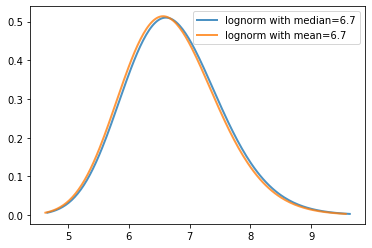

In [11]:
plot_pdf(lognorm_dist_median_approx, "lognorm with median=6.7")
plot_pdf(lognorm_dist_mean_approx, "lognorm with mean=6.7")
plt.legend();

# Try the same thing, but use my optimization routine to exactly specify the uncertainty interval

In [12]:
lognorm_dist_median, _ = two_param_distribution_from_parameter_and_interval(
    lognorm_dist_from_median_lower_upper, central_value, lower, upper
)
lognorm_dist_mean, _ = two_param_distribution_from_parameter_and_interval(
    lognorm_dist_from_mean_lower_upper, central_value, lower, upper
)
distributions = [lognorm_dist_median, lognorm_dist_mean]
for d in distributions:
    print(f"mv={d.stats()}, med={d.median()} int={d.interval(.95)}")
#     prob = d.cdf(upper) - d.cdf(lower)
#     print(f"P(X in ({lower}, {upper})) = {prob}\nrelative error = {relative_error(prob, .95)}\n")
    p_lower, p_upper = d.cdf((lower, upper))
    print(f"P(X <= {lower}) = {p_lower}, P(X <= {upper}) = {p_upper}")
    print(f"P(X in ({lower}, {upper})) = {p_upper-p_lower}")
    print(f"relative error = {relative_error(p_upper-p_lower, .95)}\n")

9
8
mv=(array(6.74634002), array(0.63175274)), med=6.7 int=(5.322734575055707, 8.433634885791802)
P(X <= 5.3) = 0.02294408972415367, P(X <= 8.4) = 0.9729433303853041
P(X in (5.3, 8.4)) = 0.9499992406611505
relative error = 7.993040520687682e-07

mv=(array(6.7), array(0.62353468)), med=6.65394677870664 int=(5.285730375626742, 8.376327316659747)
P(X <= 5.3) = 0.02637208583323215, P(X <= 8.4) = 0.9763716555063594
P(X in (5.3, 8.4)) = 0.9499995696731273
relative error = 4.5297565546451476e-07



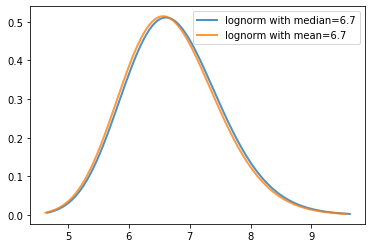

In [13]:
plot_pdf(lognorm_dist_median, "lognorm with median=6.7")
plot_pdf(lognorm_dist_mean, "lognorm with mean=6.7")
plt.legend();

# Try my optimization function with a very skewed Beta distribution

61
mv=(array(0.2), array(0.03188893)), med=0.1492706688127309 int=(0.0029896007693356944, 0.6473125749732728)
P(X <= 0.1) = 0.38087531189401674, P(X <= 0.8) = 0.9960803921542067
P(X in (0.1, 0.8)) = 0.61520508026019
relative error = 0.3524157049892736

mv=(array(0.2), array(0.00453032)), med=0.19413038880673297 int=(0.08612947568605886, 0.34684631054358617)
P(X <= 0.1) = 0.049999947448057955, P(X <= 0.8) = 0.9999999999999822
P(X in (0.1, 0.8)) = 0.9500000525519243
relative error = 5.53178151239003e-08



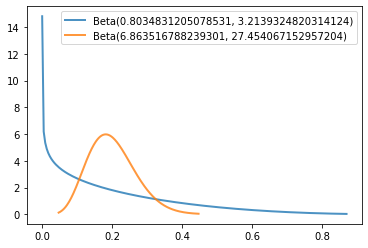

In [14]:
central_value = .2
lower = .1
upper = .8
beta_dist = beta_dist_from_mean_lower_upper(central_value, lower, upper)
beta_dist2, _ = two_param_distribution_from_parameter_and_interval(
    beta_dist_from_mean_lower_upper, central_value, lower, upper
)
distributions = [beta_dist, beta_dist2]
for d in distributions:
    print(f"mv={d.stats()}, med={d.median()} int={d.interval(.95)}")
    p_lower, p_upper = d.cdf((lower, upper))
    print(f"P(X <= {lower}) = {p_lower}, P(X <= {upper}) = {p_upper}")
    print(f"P(X in ({lower}, {upper})) = {p_upper-p_lower}")
    print(f"relative error = {relative_error(p_upper-p_lower, .95)}\n")
    plot_pdf(d, f'Beta{d.args}')
plt.legend();

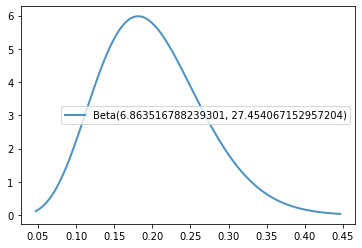

In [15]:
plot_pdf(beta_dist2, f'Beta{beta_dist2.args}')
plt.legend();

In [16]:
beta_dist.args

(0.8034831205078531, 3.2139324820314124)

# Try using my Beta distribution approximation function with the quantile ranks from the actual answer

It's close, but the relative error is still 2.8% vs. 6e-6.

mv=(array(0.2), array(0.00453032)), med=0.19413038880673297, int=(0.08612947568605886, 0.34684631054358617)
P(X <= 0.1) = 0.049999947448057955, P(X <= 0.8) = 0.9999999999999822
P(X in (0.1, 0.8)) = 0.9500000525519243
relative error = 5.53178151239003e-08

mv=(array(0.2), array(0.0057625)), med=0.19246094405353306, int=(0.07457352502765151, 0.36763310501836777)
P(X <= 0.1) = 0.07672749953757944, P(X <= 0.8) = 0.9999999999893219
P(X in (0.1, 0.8)) = 0.9232725004517425
relative error = 0.028134210050797352



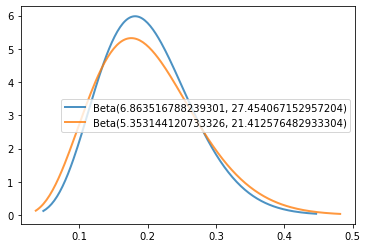

In [17]:
quantile_ranks=(0.04999455150141296,0.9999999999999822)
beta_dist3 = beta_dist_from_mean_lower_upper(central_value, lower, upper, quantile_ranks)
distributions = [beta_dist2, beta_dist3]
print_distribution_info(distributions, lower, upper)
for d in distributions:
    plot_pdf(d, f'Beta{d.args}')
plt.legend()

# Try fitting lognormal distributions with the same central value (mean or median) and interval as the skewed Beta distribution above

## First the approximate versions using the central interval

mv=(array(0.2), array(0.00453032)), med=0.19413038880673297, int=(0.08612947568605886, 0.34684631054358617)
P(X <= 0.1) = 0.049999947448057955, P(X <= 0.8) = 0.9999999999999822
P(X in (0.1, 0.8)) = 0.9500000525519243
relative error = 5.53178151239003e-08

mv=(array(0.23021684), array(0.01722466)), med=0.2, int=(0.07071067811865477, 0.565685424949238)
P(X <= 0.1) = 0.09566705117023044, P(X <= 0.8) = 0.9955161797702234
P(X in (0.1, 0.8)) = 0.899849128599993
relative error = 0.05279039094737575

mv=(array(0.2), array(0.01299979)), med=0.17374923843876283, int=(0.061429632363023776, 0.49143705890419015)
P(X <= 0.1) = 0.14884430044962516, P(X <= 0.8) = 0.9980023024289171
P(X in (0.1, 0.8)) = 0.8491580019792919
relative error = 0.10614947160074531



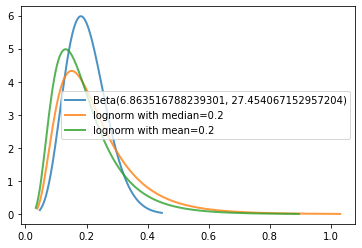

In [18]:
lognorm_dist_median_approx = lognorm_dist_from_median_lower_upper(central_value, lower, upper)
lognorm_dist_mean_approx = lognorm_dist_from_mean_lower_upper(central_value, lower, upper)

distributions = [beta_dist2, lognorm_dist_median_approx, lognorm_dist_mean_approx]
print_distribution_info(distributions, lower, upper)

plot_pdf(beta_dist2, f'Beta{beta_dist2.args}')
plot_pdf(lognorm_dist_median_approx, f"lognorm with median={central_value}")
plot_pdf(lognorm_dist_mean_approx, f"lognorm with mean={central_value}")
plt.legend();

## Now the "exact" versions using a noncentral interval

14
16
mv=(array(0.2), array(0.00453032)), med=0.19413038880673297, int=(0.08612947568605886, 0.34684631054358617)
P(X <= 0.1) = 0.049999947448057955, P(X <= 0.8) = 0.9999999999999822
P(X in (0.1, 0.8)) = 0.9500000525519243
relative error = 5.53178151239003e-08

mv=(array(0.21846094), array(0.00921715)), med=0.2, int=(0.08776942061943788, 0.4557395926473895)
P(X <= 0.1) = 0.049521582244230485, P(X <= 0.8) = 0.9995148855433849
P(X in (0.1, 0.8)) = 0.9499933032991543
relative error = 7.049158784875799e-06

mv=(array(0.2), array(0.0061391)), med=0.18621962309100604, int=(0.08879468704931938, 0.39053854657875225)
P(X <= 0.1) = 0.04993847931787217, P(X <= 0.8) = 0.99994276977266
P(X in (0.1, 0.8)) = 0.9500042904547877
relative error = 4.5162681976641e-06



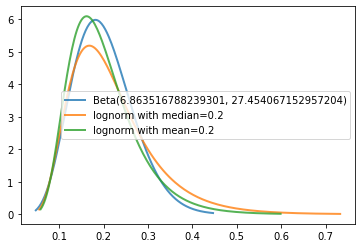

In [19]:
lognorm_dist_median, _ = two_param_distribution_from_parameter_and_interval(
    lognorm_dist_from_median_lower_upper, central_value, lower, upper
)
lognorm_dist_mean, _ = two_param_distribution_from_parameter_and_interval(
    lognorm_dist_from_mean_lower_upper, central_value, lower, upper
)
distributions = [beta_dist2, lognorm_dist_median, lognorm_dist_mean]
print_distribution_info(distributions, lower, upper)

plot_pdf(beta_dist2, f'Beta{beta_dist2.args}')
plot_pdf(lognorm_dist_median, f"lognorm with median={central_value}")
plot_pdf(lognorm_dist_mean, f"lognorm with mean={central_value}")
plt.legend();

# Try creating a beta distribution with asymptotes at the endpoints

It doesn't work because a normal distribution cannot have sufficiently large variance to get a wide enough uncertainty interval.

<ipython-input-3-814351aa6776>:29: RuntimeWarning: divide by zero encountered in double_scalars
  a = mean*(mean*(1-mean)/variance - 1)
<ipython-input-3-814351aa6776>:30: RuntimeWarning: divide by zero encountered in double_scalars
  b = (1-mean)*(mean*(1-mean)/variance - 1)


1000
mv=(array(0.5), array(0.0625023)), med=0.5, int=(0.06082503508607194, 0.939174964913928)
P(X <= 0.01) = 0.001692986860336945, P(X <= 0.99) = 0.9983070131396631
P(X in (0.01, 0.99)) = 0.9966140262793262
relative error = 0.04906739608350127

mv=(array(nan), array(nan)), med=nan, int=(nan, nan)
P(X <= 0.01) = nan, P(X <= 0.99) = nan
P(X in (0.01, 0.99)) = nan
relative error = nan



/Users/ndbs/miniconda3/envs/py38/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:608: RuntimeWarning: invalid value encountered in true_divide
  mn = a*1.0 / (a + b)
/Users/ndbs/miniconda3/envs/py38/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:609: RuntimeWarning: invalid value encountered in true_divide
  var = (a*b*1.0)/(a+b+1.0)/(a+b)**2.0
/Users/ndbs/miniconda3/envs/py38/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:610: RuntimeWarning: invalid value encountered in subtract
  g1 = 2.0*(b-a)*np.sqrt((1.0+a+b)/(a*b)) / (2+a+b)
/Users/ndbs/miniconda3/envs/py38/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:610: RuntimeWarning: invalid value encountered in true_divide
  g1 = 2.0*(b-a)*np.sqrt((1.0+a+b)/(a*b)) / (2+a+b)
/Users/ndbs/miniconda3/envs/py38/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:611: RuntimeWarning: invalid value encountered in add
  g2 = 6.0*(a**3 + a**2*(1-2*b) + b**2*(1+b) - 2*a*b*(2+b))


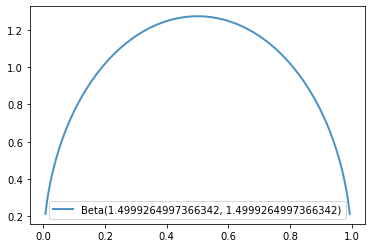

In [20]:
central_value = .5
lower = .01
upper = 1-lower
beta_dist = beta_dist_from_mean_lower_upper(central_value, lower, upper)
beta_dist2, _ = two_param_distribution_from_parameter_and_interval(
    beta_dist_from_mean_lower_upper, central_value, lower, upper
)
distributions = [beta_dist, beta_dist2]
print_distribution_info(distributions, lower, upper)
plot_pdf(beta_dist, f'Beta{beta_dist.args}')
plt.legend();

0.2500045938930804
0.06250229696764405


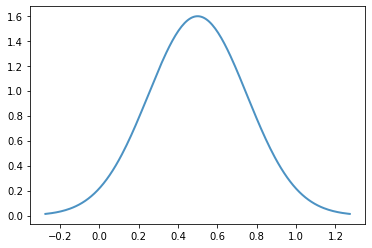

In [21]:
central_value = .5
lower = .01
upper = 1-lower
normal_stdev_from_quantiles((lower, upper), (.025, .975))
norm_dist = normal_dist_from_mean_lower_upper(central_value, lower, upper)
print(norm_dist.var()**.5)
print(norm_dist.var())
plot_pdf(norm_dist, "Normal")

In [22]:
beta_dist.var()**.5

0.2500045938930804

In [23]:
0.2500045938930804 - 0.5*(1-0.5)

4.593893080384603e-06

In [24]:
# Fails with ValueError: Variance too large: 0.2500045938930804 >= 0.25

#beta_dist_from_mean_var(.5, 0.2500045938930804)

In [25]:
norm_dist.kwds

{'loc': 0.5, 'scale': 0.2500045938930804}

# Try normal distributions with either a very asymmetric interval or an interval that doesn't contain the mean

24
mv=(array(10.), array(26.03177716)), med=10.0, int=(0.0, 20.0)
P(X <= 5) = 0.16354750384557037, P(X <= 25) = 0.998358652617729
P(X in (5, 25)) = 0.8348111487721587
relative error = 0.12125142234509609

mv=(array(10.), array(9.24119736)), med=10.0, int=(4.041839283021648, 15.958160716978352)
P(X <= 5) = 0.05000834989614691, P(X <= 25) = 0.9999995978435084
P(X in (5, 25)) = 0.9499912479473616
relative error = 9.212686987783583e-06



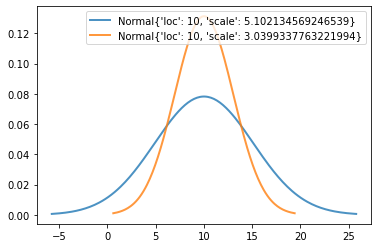

In [26]:
central_value = 10
lower = 5
upper = 25
norm_dist = normal_dist_from_mean_lower_upper(central_value, lower, upper)
norm_dist2, _ = two_param_distribution_from_parameter_and_interval(
    normal_dist_from_mean_lower_upper, central_value, lower, upper
)
distributions = [norm_dist, norm_dist2]
print_distribution_info(distributions, lower, upper)
for d in distributions:
    plot_pdf(d, f'Normal{d.kwds}')
plt.legend();

/Users/ndbs/miniconda3/envs/py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1844: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/ndbs/miniconda3/envs/py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/ndbs/miniconda3/envs/py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


1000
mv=(array(10.), array(34.05207114)), med=10.0, int=(7.751495074210039, 12.24850492578996)
P(X <= 12) = 0.6341010178085826, P(X <= 18) = 0.9148030579089625
P(X in (12, 18)) = 0.2807020401003799
relative error = 0.06432653299873359

mv=(array(nan), array(nan)), med=nan, int=(nan, nan)
P(X <= 12) = nan, P(X <= 18) = nan
P(X in (12, 18)) = nan
relative error = nan



/Users/ndbs/miniconda3/envs/py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/ndbs/miniconda3/envs/py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


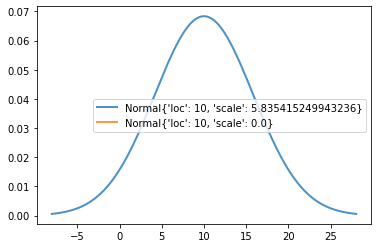

In [27]:
central_value = 10
lower = 12
upper = 18
desired_prob = .3
p0=.6
norm_dist = normal_dist_from_mean_lower_upper(central_value, lower, upper, (p0, p0+desired_prob))
norm_dist2, pvals = two_param_distribution_from_parameter_and_interval(
    normal_dist_from_mean_lower_upper, central_value, lower, upper, desired_prob
)
distributions = [norm_dist, norm_dist2]
print_distribution_info(distributions, lower, upper, desired_prob)
for d in distributions:
    plot_pdf(d, f'Normal{d.kwds}')
plt.legend();

In [28]:
pvals[:20]

[0.35,
 0.5249999999999999,
 0.6124999999999999,
 0.65625,
 0.678125,
 0.6890624999999999,
 0.6945312499999999,
 0.697265625,
 0.6986328125,
 0.6993164062499999,
 0.6996582031249999,
 0.6998291015625,
 0.69991455078125,
 0.6999572753906249,
 0.6999786376953124,
 0.6999893188476562,
 0.6999946594238281,
 0.699997329711914,
 0.699998664855957,
 0.6999993324279785]

In [29]:
for p in pvals[:7]:
#     p = 0.6945312499999999
    d = normal_dist_from_mean_lower_upper(central_value, lower, upper, (p, p+desired_prob))
    print_distribution_info([d], lower, upper, desired_prob)

mv=(array(10.), array(60.61754658)), med=10.0, int=(6.999999999999998, 13.000000000000002)
P(X <= 12) = 0.6013644148603415, P(X <= 18) = 0.8479124562677041
P(X in (12, 18)) = 0.24654804140736253
relative error = 0.17817319530879155

mv=(array(10.), array(47.3572599)), med=10.0, int=(7.348355123966128, 12.651644876033872)
P(X <= 12) = 0.614331888911873, P(X <= 18) = 0.8774858210112295
P(X in (12, 18)) = 0.26315393209935656
relative error = 0.12282022633547811

mv=(array(10.), array(31.4161378)), med=10.0, int=(7.840274908681339, 12.159725091318661)
P(X <= 12) = 0.6393880750383334, P(X <= 18) = 0.9232524864876762
P(X in (12, 18)) = 0.2838644114493428
relative error = 0.05378529516885722

mv=(array(10.), array(21.09082252)), med=10.0, int=(8.230425563400846, 11.769574436599154)
P(X <= 12) = 0.6683984395367096, P(X <= 18) = 0.9592440504779426
P(X in (12, 18)) = 0.29084561094123296
relative error = 0.030514630195890107

mv=(array(10.), array(14.90704208)), med=10.0, int=(8.512291597166998, 

15
mv=(array(10.), array(58.70610455)), med=10.0, int=(7.558588092918985, 12.441411907081015)
P(X <= 12) = 0.602964836512283, P(X <= 18) = 0.8517839178426838
P(X in (12, 18)) = 0.24881908133040076
relative error = 0.004723674678396961

mv=(array(10.), array(57.72701808)), med=10.0, int=(7.579032336444821, 12.420967663555178)
P(X <= 12) = 0.6038145248351834, P(X <= 18) = 0.8538139762923864
P(X in (12, 18)) = 0.24999945145720304
relative error = 2.1941711878525894e-06



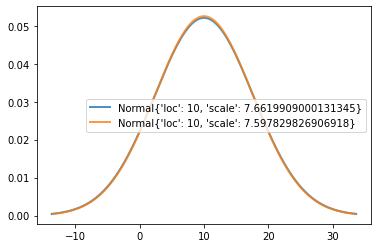

In [30]:
central_value = 10
lower = 12
upper = 18
desired_prob = .25
p0=.6
norm_dist = normal_dist_from_mean_lower_upper(central_value, lower, upper, (p0, p0+desired_prob))
norm_dist2, pvals = two_param_distribution_from_parameter_and_interval(
    normal_dist_from_mean_lower_upper, central_value, lower, upper, desired_prob
)
distributions = [norm_dist, norm_dist2]
print_distribution_info(distributions, lower, upper, desired_prob)
for d in distributions:
    plot_pdf(d, f'Normal{d.kwds}')
plt.legend();

In [31]:
0.249998882775621/.25

0.999995531102484

In [32]:
desired_prob

0.25

In [33]:
relative_error(0.8538129951732907-0.6038141123976697, desired_prob)

4.4688975160411815e-06

# Try finding beta distributions with asymptotes again, but use the method of moments approach to directly find the variance rather than trying to guess standard deviation from normal distribution

15
mv=(array(0.5), array(0.0625023)), med=0.5, int=(0.06082503508607194, 0.939174964913928)
P(X <= 0.01) = 0.001692986860336945, P(X <= 0.99) = 0.9983070131396631
P(X in (0.01, 0.99)) = 0.9966140262793262
relative error = 0.04906739608350127

mv=(array(0.5), array(0.10007477)), med=0.4999999999999998, int=(0.010001760198720828, 0.9899982398012792)
P(X <= 0.01) = 0.024996699483112773, P(X <= 0.99) = 0.9750033005168872
P(X in (0.01, 0.99)) = 0.9500066010337744
relative error = 6.948456604713876e-06



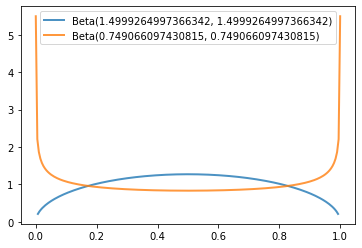

In [34]:
mean = .5
lower = .01
upper = 1-lower
desired_prob = .95
beta_dist = beta_dist_from_mean_lower_upper(mean, lower, upper)
beta_dist2 = two_param_distribution_from_mean_and_interval(
    beta_dist_from_mean_var, mean, lower, upper, desired_prob, mean*(1-mean)
)
distributions = [beta_dist, beta_dist2]
print_distribution_info(distributions, lower, upper)
for d in distributions:
    plot_pdf(d, f'Beta{d.args}')
plt.legend();

15
mv=(array(0.25), array(0.0625023)), med=0.16318945476359323, int=(0.00038544673004377387, 0.8532648233409919)
P(X <= 0.01) = 0.1271221925881281, P(X <= 0.99) = 0.9995741626760686
P(X in (0.01, 0.99)) = 0.8724519700879405
relative error = 0.0816295051705889

mv=(array(0.25), array(0.04398537)), med=0.19629693463982267, int=(0.004255663148273274, 0.750153689950152)
P(X <= 0.01) = 0.04999927206496351, P(X <= 0.99) = 0.9999908280846805
P(X in (0.01, 0.99)) = 0.9499915560197171
relative error = 8.888400297767912e-06



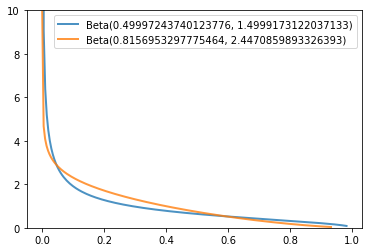

In [35]:
mean = .25
lower = .01
upper = 1-lower
desired_prob = .95
beta_dist = beta_dist_from_mean_lower_upper(mean, lower, upper)
beta_dist2 = two_param_distribution_from_mean_and_interval(
    beta_dist_from_mean_var, mean, lower, upper, desired_prob, mean*(1-mean)
)
distributions = [beta_dist, beta_dist2]
print_distribution_info(distributions, lower, upper)
for d in distributions:
    plot_pdf(d, f'Beta{d.args}')
plt.ylim((0,10))
plt.legend();

14
mv=(array(0.5), array(0.06481939)), med=0.5, int=(0.05569659251572828, 0.9443034074842718)
P(X <= 0.001) = 8.132749378788855e-05, P(X <= 0.999) = 0.9999186725062121
P(X in (0.001, 0.999)) = 0.9998373450124243
relative error = 0.05246036317097297

mv=(array(0.5), array(0.12956238)), med=0.5000000000000001, int=(0.0009998207716162848, 0.9990001792283837)
P(X <= 0.001) = 0.0250020836071673, P(X <= 0.999) = 0.9749979163928327
P(X in (0.001, 0.999)) = 0.9499958327856655
relative error = 4.386541404730487e-06



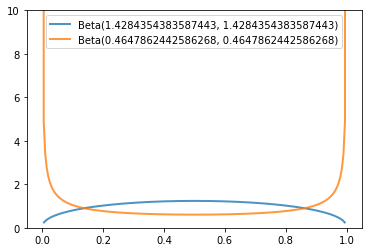

In [36]:
mean = .5
lower = .001
upper = 1-lower
desired_prob = .95
beta_dist = beta_dist_from_mean_lower_upper(mean, lower, upper)
beta_dist2 = two_param_distribution_from_mean_and_interval(
    beta_dist_from_mean_var, mean, lower, upper, desired_prob, mean*(1-mean)
)
distributions = [beta_dist, beta_dist2]
print_distribution_info(distributions, lower, upper)
for d in distributions:
    plot_pdf(d, f'Beta{d.args}')
plt.ylim((0,10))
plt.legend();

20
mv=(array(0.5), array(0.00260318)), med=0.49999999999999994, int=(0.499355477024183, 0.500644522975817)
P(X <= 0.4) = 0.024735619450978064, P(X <= 0.6) = 0.975264380549022
P(X in (0.4, 0.6)) = 0.950528761098044
relative error = 94.05287610980439

mv=(array(0.5), array(0.23785329)), med=0.5, int=(0.39999950512256993, 0.6000004948774291)
P(X <= 0.4) = 0.4950000254096919, P(X <= 0.6) = 0.504999974590308
P(X in (0.4, 0.6)) = 0.009999949180616086
relative error = 5.081938391458818e-06



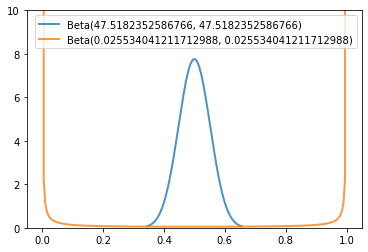

In [37]:
mean = .5
lower = .4
upper = 1-lower
desired_prob = .01
beta_dist = beta_dist_from_mean_lower_upper(mean, lower, upper)
beta_dist2 = two_param_distribution_from_mean_and_interval(
    beta_dist_from_mean_var, mean, lower, upper, desired_prob, mean*(1-mean)
)
distributions = [beta_dist, beta_dist2]
print_distribution_info(distributions, lower, upper, desired_prob)
for d in distributions:
    plot_pdf(d, f'Beta{d.args}')
plt.ylim((0,10))
plt.legend();